In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,tod_sin,tod_cos
0,23.18,27.2720,721.25,1,0,-0.999229,-0.039260
1,23.15,27.2675,714.00,1,0,-0.999229,-0.039260
2,23.15,27.2450,713.50,1,0,-0.999534,-0.030539
3,23.15,27.2000,708.25,1,0,-0.999657,-0.026177
4,23.10,27.2000,704.50,1,0,-0.999762,-0.021815


In [4]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

1
0
5


In [5]:
for df in [df_train, df_test]:
    df.drop_duplicates(inplace=True)

In [6]:
# Preparing data for CNN model,
target = 'Occupancy'
features = ["Temperature", "Humidity", "CO2", "weekend", "tod_sin", "tod_cos"]

X_train = df_train[features].values
y_train = df_train[target].values.astype(int)

X_val = df_val[features].values
y_val = df_val[target].values.astype(int)

X_test = df_test[features].values
y_test = df_test[target].values.astype(int)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling the features, I will fit only the train  DS
# Because the weekend is binary and tod_sin, tod_cos are already normialized, to -1 , 1. So I will Standardize the continuous features.
scaler = StandardScaler()
X_train_scaled[:, 0:3] = scaler.fit_transform(X_train_scaled[:, 0:3])

# transforming val and test DS 
X_val_scaled[:, 0:3] = scaler.transform(X_val_scaled[:, 0:3])
X_test_scaled[:, 0:3]= scaler.transform(X_test_scaled[:, 0:3])

print("Train:", X_train_scaled.shape, y_train.shape)
print("Val:", X_val_scaled.shape, y_val.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

Train: (8117, 6) (8117,)
Val: (2663, 6) (2663,)
Test: (9720, 6) (9720,)


In [7]:
# Checking the weekend and tod_sin, tod_cos. 
print("weekend unique:", np.unique(X_train_scaled[:,3]))
print("tod_sin min/max:", X_train_scaled[:,4].min(), X_train_scaled[:,4].max())
print("tod_cos min/max:", X_train_scaled[:,5].min(), X_train_scaled[:,5].max())

weekend unique: [0. 1.]
tod_sin min/max: -1.0 1.0
tod_cos min/max: -1.0 1.0


In [8]:
# MAKING SEQUENCES:
# The CNN model for time series, needs sequences as input 
# I will create windows of minutes that the model will predict right after the window, the next minute

# Creating function

window_size = 60
step_ahead = 1
def windows_time(X, y, window_size = None, step_ahead = None):
   # I will creaate two lists for storing  features and the target
   # The end should start the a window
   X_windows = []
   y_windows = []
   last_start = len(X) - window_size - step_ahead + 1
   for start in range(last_start):
        end = start + window_size
        X_windows.append(X[start:end])                  
        y_windows.append(y[end + step_ahead - 1])      
   return np.array(X_windows), np.array(y_windows)

  
X_train_window, y_train_window = windows_time(X_train_scaled, y_train, window_size, step_ahead)
X_val_window, y_val_window = windows_time(X_val_scaled, y_val, window_size, step_ahead)
X_test_window, y_test_window = windows_time(X_test_scaled, y_test, window_size, step_ahead)

print("Train windows:", X_train_window.shape, y_train_window.shape)
print("Val windows:", X_val_window.shape,y_val_window.shape)
print("Test windows:", X_test_window.shape, y_test_window.shape)

Train windows: (8057, 60, 6) (8057,)
Val windows: (2603, 60, 6) (2603,)
Test windows: (9660, 60, 6) (9660,)


In [9]:
X_train_tensor = torch.tensor(X_train_window, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_window, dtype=torch.long) 
X_val_tensor = torch.tensor(X_val_window, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_window, dtype=torch.long)
X_test_tensor= torch.tensor(X_test_window, dtype=torch.float32)
y_test_tensor= torch.tensor(y_test_window, dtype=torch.long)

In [10]:
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# I nned to see shape of one batch
for X_batch, y_batch in train_loader:
    print(f"Batch input shape: {X_batch.shape}") 
    print(f"Batch target shape: {y_batch.shape}")
    break  
# In forward function, I will switch input shape and sequence lemght

Batch input shape: torch.Size([128, 60, 6])
Batch target shape: torch.Size([128])


In [12]:
class OccupancyCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # First Block 
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        # In first block, the sequence length reduces from 20 to 10
        # Second Block
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        # In second block, the sequence length reduces from 10 to 5
        self.fc1   = nn.Linear(32 * 15 , 32)  
        self.fc2   = nn.Linear(32, 1)
        self.drop_conv = nn.Dropout(p=0.5)  
        self.drop_fc   = nn.Dropout(p=0.2) 

    def forward(self, x):
        x = x.transpose(1, 2).contiguous()
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))   
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.drop_conv(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.drop_conv(x)

        x = torch.flatten(x, start_dim=1)  
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)       
        return x
model = OccupancyCNN().to(device)
model
# Sources :
# https://medium.com/@ugamakelechi501/building-a-convolutional-neural-network-cnn-from-scratch-with-pytorch-eca3ffdcf2ff
# https://www.dkneup.com/blog/cnn-time-series-forecasting-in-tensorflow-pytorch

OccupancyCNN(
  (conv1): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=480, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (drop_conv): Dropout(p=0.5, inplace=False)
  (drop_fc): Dropout(p=0.2, inplace=False)
)

In [13]:
# My target column is imbalanced, there is more 0 than 1
# I need to calculate class weights, that loss function focus more on the unoccupany class.
# First I should convert it back to numpy
y_np = y_train
class_weights = compute_class_weight('balanced', classes=np.unique(y_np), y=y_np)
one_weight = torch.tensor(class_weights[1], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=one_weight)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00001)
# If val loss does not improve for 5 epochs, lr is going to be cut by half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
print('Optimizer:', optimizer)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 1e-05
)


In [15]:
epochs = 20
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(1, epochs+1):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)            
        loss = criterion(outputs.squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float() 
        correct += (preds.squeeze() == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    


    val_loss = 0.0
    val_preds = []
    val_targets = []
    model.eval()  
     
    with torch.no_grad():  
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits.squeeze(1), y_batch.float())
            val_loss += loss.item() * X_batch.size(0)


            probs = torch.sigmoid(logits.squeeze(1))
            preds = (probs >= 0.5).to(torch.int64)


            val_preds.extend(preds.tolist())
            val_targets.extend(y_batch.tolist())
    val_loss = val_loss / len(val_dataset)


    
    # Converting predictions and targets to numpy for calculations
    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)
    
    val_prec = precision_score(val_targets, val_preds, pos_label=1.0, zero_division=0)
    learning_rate = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch:2d}/{epochs} - "f"Train Loss: {train_loss:.4f} "f"Val Loss: {val_loss:.4f}, "
          f"Prec: {val_prec:.3f}, "f"Learning Rate: {learning_rate:.6f}")
    

    scheduler.step(val_loss)


    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
if patience_counter >= patience:
    model.load_state_dict(best_model_state)
#Source: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html

Epoch  1/20 - Train Loss: 0.3523 Val Loss: 0.3502, Prec: 0.792, Learning Rate: 0.000500
Epoch  2/20 - Train Loss: 0.1275 Val Loss: 0.2385, Prec: 0.867, Learning Rate: 0.000500
Epoch  3/20 - Train Loss: 0.1011 Val Loss: 0.2733, Prec: 0.903, Learning Rate: 0.000500
Epoch  4/20 - Train Loss: 0.0841 Val Loss: 0.2831, Prec: 0.909, Learning Rate: 0.000500
Early stopping triggered.


In [16]:
# Evaluation
model.eval()
test_preds = []
test_targets = []
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = criterion(logits.squeeze(), y_batch.float())
        probs = torch.sigmoid(logits.squeeze())
        preds = (probs >= 0.5).to(torch.int64)
        test_loss += loss.item() * X_batch.size(0)

        test_preds.extend(preds.tolist())
        test_targets.extend(y_batch.tolist())
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

Confusion Matrix:


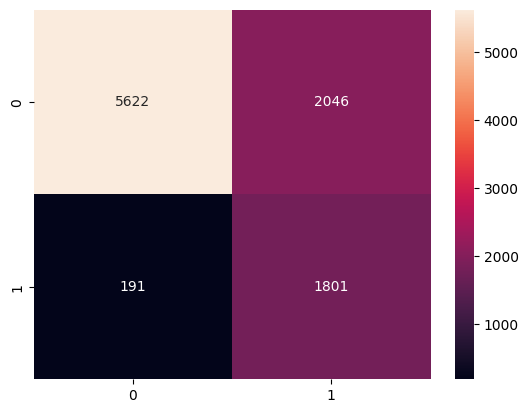

In [17]:
Confusion_matrix = confusion_matrix(test_targets, test_preds)
print("Confusion Matrix:")
sns.heatmap(Confusion_matrix, annot=True, fmt='d')
plt.show()

In [19]:
Classification_report = classification_report(test_targets, test_preds, target_names=['No Occupancy', 'Occupancy'], zero_division=0)
print("Classification Report:\n", Classification_report)

# Even though I have calculated class weights, but still the model is biased towards the class occupancy.
# The gap between traning and validation loss is big, because the distribution of Occupancy is different in each DS.

Classification Report:
               precision    recall  f1-score   support

No Occupancy       0.97      0.73      0.83      7668
   Occupancy       0.47      0.90      0.62      1992

    accuracy                           0.77      9660
   macro avg       0.72      0.82      0.73      9660
weighted avg       0.86      0.77      0.79      9660

